In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from __future__ import print_function
import numpy as np
from numpy import linalg as LA
import torch
import numpy as np
import sys, os 

import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import timeit
import time

get_ipython().run_line_magic('matplotlib', 'inline')
import sys, os # tag:RNA # for the import of AccModule
sys.path.append('C:/Users/lenovo/Desktop/opt/') # tag:RNA # import path for AccModule
#import AccelerationModule # tag:RNA # import AccModule

In [3]:
num_workers = 2
batch_size = 100
valid_size = 0.2
# Data augmentation for train data + conversion to tensor
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])
# Data augmentation for test data + conversion to tensor
test_transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
# Picking Fashion-MNIST dataset
train_data = datasets.FashionMNIST('Dataset', train=True, download=True, transform=train_transforms)
test_data = datasets.FashionMNIST('Dataset', train=False, download=True, transform=test_transforms)

Extracting Dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to Dataset/FashionMNIST/raw


Extracting Dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Dataset/FashionMNIST/raw


Extracting Dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Dataset/FashionMNIST/raw


Extracting Dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Dataset/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:

# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))

#Randomize indices
np.random.shuffle(indices)
split = int(np.floor(num_train*valid_size))
train_index, test_index = indices[split:], indices[:split]

# Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Image classes
classes = ['T-shirt/top','Trouser','Pullover','Dress',
           'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [5]:
print('number of samples of training set after data loading: ',len(train_loader))
print('number of samples of valid set after data loading',len(valid_loader))
print('number of samples of test set after data loading',len(test_loader))

number of samples of training set after data loading:  480
number of samples of valid set after data loading 120
number of samples of test set after data loading 100


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = Net()
print(model)
#modelAcc = Net() # tag:RNA # modelAcc is a copy of the network
#print(modelAcc)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [7]:
criterion = nn.CrossEntropyLoss()


In [10]:
##SGD optimizer

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, dampening = 0, weight_decay = 0)

In [15]:
##training without RNA
# epochs to train for
epochs = 25
sgd1_train_loss_history=[]
sgd1_train_acc_history=[]
sgd1_valid_loss_history=[]
sgd1_valid_acc_history=[]
sgd1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    sgd1_train_loss = 0
    sgd1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        sgd1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        sgd1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    sgd1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    sgd1_train_loss = sgd1_train_loss/len(train_loader.sampler)
    sgd1_valid_loss = sgd1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    sgd1_epoch_acc = 100 * correct/ total

    sgd1_train_loss_history.append(sgd1_train_loss)
    sgd1_train_acc_history.append(sgd1_epoch_acc)
    
    sgd1_valid_loss_history.append(sgd1_valid_loss)
    sgd1_valid_acc_history.append(sgd1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(sgd1_train_loss, 6)}\nValidation Loss: {round(sgd1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if sgd1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(sgd1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = sgd1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 0.430402
Validation Loss: 0.386021
Validation loss decreased from inf to 0.386021
Saving New Model
Current Epoch: 2
Training Loss: 0.426306
Validation Loss: 0.389321
Current Epoch: 3
Training Loss: 0.417683
Validation Loss: 0.376282
Validation loss decreased from 0.386021 to 0.376282
Saving New Model
Current Epoch: 4
Training Loss: 0.413955
Validation Loss: 0.365256
Validation loss decreased from 0.376282 to 0.365256
Saving New Model
Current Epoch: 5
Training Loss: 0.409233
Validation Loss: 0.365002
Validation loss decreased from 0.365256 to 0.365002
Saving New Model
Current Epoch: 6
Training Loss: 0.40903
Validation Loss: 0.379566
Current Epoch: 7
Training Loss: 0.402242
Validation Loss: 0.365765
Current Epoch: 8
Training Loss: 0.397531
Validation Loss: 0.364538
Validation loss decreased from 0.365002 to 0.364538
Saving New Model
Current Epoch: 9
Training Loss: 0.396545
Validation Loss: 0.355912
Validation loss decreased from 0.364538 to 0.355912
Saving

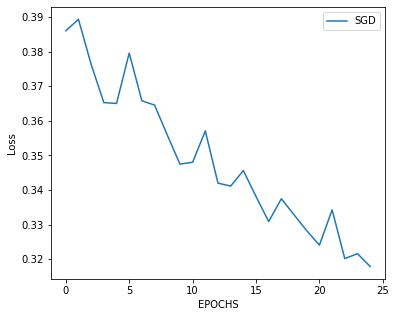

In [16]:
plt.figure(figsize=(6, 5))
plt.plot(sgd1_valid_loss_history, label='SGD')

plt.xlabel('EPOCHS')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

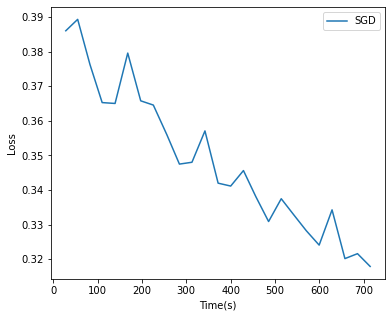

In [19]:
plt.figure(figsize=(6, 5))
plt.plot(sgd1_time,sgd1_valid_loss_history, label='SGD')

plt.xlabel('Time(s)')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()



In [20]:
##Nestrov
##

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)

In [21]:
##training without RNA
# epochs to train for
epochs = 25
nest1_train_loss_history=[]
nest1_train_acc_history=[]
nest1_valid_loss_history=[]
nest1_valid_acc_history=[]
nest1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    nest1_train_loss = 0
    nest1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        nest1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        nest1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    nest1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    nest1_train_loss = nest1_train_loss/len(train_loader.sampler)
    nest1_valid_loss = nest1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    nest1_epoch_acc = 100 * correct/ total

    nest1_train_loss_history.append(nest1_train_loss)
    nest1_train_acc_history.append(nest1_epoch_acc)
    
    nest1_valid_loss_history.append(nest1_valid_loss)
    nest1_valid_acc_history.append(nest1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(nest1_train_loss, 6)}\nValidation Loss: {round(nest1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if nest1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(nest1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = nest1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 0.351131
Validation Loss: 0.321107
Validation loss decreased from inf to 0.321107
Saving New Model
Current Epoch: 2
Training Loss: 0.344426
Validation Loss: 0.320976
Validation loss decreased from 0.321107 to 0.320976
Saving New Model
Current Epoch: 3
Training Loss: 0.344826
Validation Loss: 0.314357
Validation loss decreased from 0.320976 to 0.314357
Saving New Model
Current Epoch: 4
Training Loss: 0.34215
Validation Loss: 0.315424
Current Epoch: 5
Training Loss: 0.339049
Validation Loss: 0.310578
Validation loss decreased from 0.314357 to 0.310578
Saving New Model
Current Epoch: 6
Training Loss: 0.337824
Validation Loss: 0.307795
Validation loss decreased from 0.310578 to 0.307795
Saving New Model
Current Epoch: 7
Training Loss: 0.338388
Validation Loss: 0.306885
Validation loss decreased from 0.307795 to 0.306885
Saving New Model
Current Epoch: 8
Training Loss: 0.338626
Validation Loss: 0.308664
Current Epoch: 9
Training Loss: 0.333585
Validation Loss

Text(0, 0.5, 'loss')

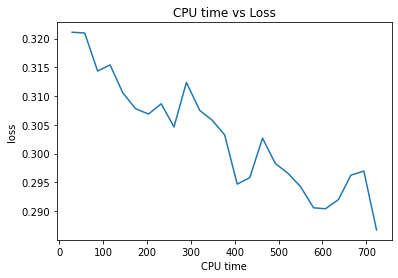

In [22]:
plt.plot(nest1_time, nest1_valid_loss_history)
plt.title('CPU time vs Loss')
plt.xlabel('CPU time')
plt.ylabel('loss')

In [27]:
##GD

##GD using RMS prop

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

##nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [28]:
##training without RNA
# epochs to train for
epochs = 25
gd1_train_loss_history=[]
gd1_train_acc_history=[]
gd1_valid_loss_history=[]
gd1_valid_acc_history=[]
gd1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    gd1_train_loss = 0
    gd1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        gd1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        gd1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    gd1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    gd1_train_loss = gd1_train_loss/len(train_loader.sampler)
    gd1_valid_loss = gd1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    gd1_epoch_acc = 100 * correct/ total

    gd1_train_loss_history.append(gd1_train_loss)
    gd1_train_acc_history.append(gd1_epoch_acc)
    
    gd1_valid_loss_history.append(gd1_valid_loss)
    gd1_valid_acc_history.append(gd1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(gd1_train_loss, 6)}\nValidation Loss: {round(gd1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if gd1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(gd1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = gd1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 2.303632
Validation Loss: 2.302857
Validation loss decreased from inf to 2.302857
Saving New Model
Current Epoch: 2
Training Loss: 2.302711
Validation Loss: 2.302743
Validation loss decreased from 2.302857 to 2.302743
Saving New Model
Current Epoch: 3
Training Loss: 2.310802
Validation Loss: 2.302703
Validation loss decreased from 2.302743 to 2.302703
Saving New Model
Current Epoch: 4
Training Loss: 2.302712
Validation Loss: 2.302683
Validation loss decreased from 2.302703 to 2.302683
Saving New Model
Current Epoch: 5
Training Loss: 2.302689
Validation Loss: 2.302711
Current Epoch: 6
Training Loss: 2.302704
Validation Loss: 2.302725
Current Epoch: 7
Training Loss: 2.302694
Validation Loss: 2.302702
Current Epoch: 8
Training Loss: 2.302704
Validation Loss: 2.30273
Current Epoch: 9
Training Loss: 2.302701
Validation Loss: 2.302648
Validation loss decreased from 2.302683 to 2.302648
Saving New Model
Current Epoch: 10
Training Loss: 2.302693
Validation Loss:

In [29]:
##GD plus momentum

##GD using RMS prop

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)

In [30]:
##training without RNA
# epochs to train for
epochs = 25
gdm1_train_loss_history=[]
gdm1_train_acc_history=[]
gdm1_valid_loss_history=[]
gdm1_valid_acc_history=[]
gdm1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    gdm1_train_loss = 0
    gdm1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        gdm1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        gdm1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    gdm1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    gdm1_train_loss = gdm1_train_loss/len(train_loader.sampler)
    gdm1_valid_loss = gdm1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    gdm1_epoch_acc = 100 * correct/ total

    gdm1_train_loss_history.append(gdm1_train_loss)
    gdm1_train_acc_history.append(gdm1_epoch_acc)
    
    gdm1_valid_loss_history.append(gdm1_valid_loss)
    gdm1_valid_acc_history.append(gdm1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(gdm1_train_loss, 6)}\nValidation Loss: {round(gdm1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if gdm1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(gdm1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = gdm1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 2.906495
Validation Loss: 2.309842
Validation loss decreased from inf to 2.309842
Saving New Model
Current Epoch: 2
Training Loss: 2.312214
Validation Loss: 2.307208
Validation loss decreased from 2.309842 to 2.307208
Saving New Model
Current Epoch: 3
Training Loss: 2.312264
Validation Loss: 2.308797
Current Epoch: 4
Training Loss: 2.314089
Validation Loss: 2.316512
Current Epoch: 5
Training Loss: 2.310342
Validation Loss: 2.31017
Current Epoch: 6
Training Loss: 2.310074
Validation Loss: 2.309506
Current Epoch: 7
Training Loss: 2.310068
Validation Loss: 2.308292
Current Epoch: 8
Training Loss: 2.311807
Validation Loss: 2.31317
Current Epoch: 9
Training Loss: 2.31041
Validation Loss: 2.308158
Current Epoch: 10
Training Loss: 2.309632
Validation Loss: 2.306271
Validation loss decreased from 2.307208 to 2.306271
Saving New Model
Current Epoch: 11
Training Loss: 2.309176
Validation Loss: 2.308831
Current Epoch: 12
Training Loss: 2.309672
Validation Loss: 2.3

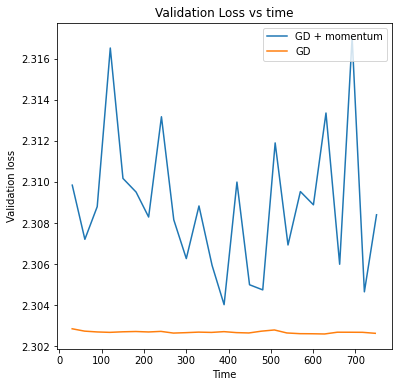

In [34]:
plt.figure(figsize=(6, 6))
#plt.plot(sgd1_time,sgd1_valid_loss_history, label='SGD + momentum')
plt.plot(gdm1_time,gdm1_valid_loss_history, label='GD + momentum')
plt.plot(gd1_time,gd1_valid_loss_history, label='GD')
#plt.plot(nest1_time, nest1_valid_loss_history, label='NESTROV')

#plt.plot(sgd1_valid_loss_history,'r--', label='SGD')
#plt.plot(gd1_valid_loss_history,'b--', label='GD')
#plt.plot(nest1_valid_loss_history, 'g--', label='NESTROV')


plt.legend(loc="upper right")
plt.xlabel('Time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

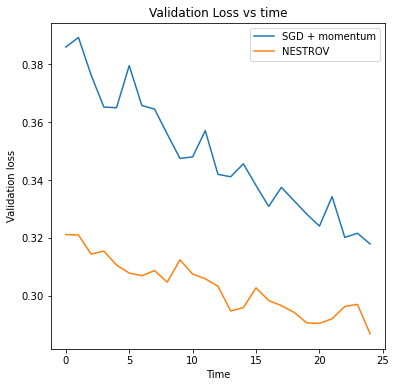

In [33]:
plt.figure(figsize=(6, 6))
plt.plot(sgd1_valid_loss_history, label='SGD + momentum')
#plt.plot(gdm1_valid_loss_history, label='GD + momentum')
#plt.plot(gd1_valid_loss_history, label='GD')
plt.plot(nest1_valid_loss_history, label='NESTROV')

plt.legend(loc="upper right")
plt.xlabel('Time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()


RNA PLUS OPTIMIZERS

In [35]:
# Copy and Paste ---- everything I did here
from numpy import linalg as LA


class myRNA:
    def rna(self, X,reg=0):
        # Regularized Nonlinear Acceleration
        # Take a matrix X of iterates, where X[:,i] is the ith iteration of the
        # fixed-point operation
        #   x_i = g(x_{i-1})
        #
        # reg is the regularization parameter used for solving the system
        #   (R'R + reg I)z = 1
        # where R is the matrix of residuals, i.e. R[:,i] = x_{i+1}-x_{i}
      
      
        # Recovers parameters, ensure X is a matrix
        (d,k) = np.shape(X);
        k = k-1;
        X = np.asmatrix(X); # check if necessary
        
        # Compute the matrix of residuals
        R = np.diff(X);
        
        # "Square" the matrix, and normalize it
        RR = np.dot(np.transpose(R),R);
        normRR = LA.norm(RR,2);
        RR = RR/normRR;
        
        # Solve (R'R + lambda I)z = 1
        (extr,c) = self.rna_precomputed(X,RR,reg)
        # Compute the extrapolation / weigthed mean  "sum_i c_i x_i", and return
        return extr,c
    
    def min_eignevalRR(self, X):
        # Recovers parameters, ensure X is a matrix
        (d,k) = np.shape(X);
        k = k-1;
        X = np.asmatrix(X);
        
        # Compute the matrix of residuals
        R = np.diff(X);
        
        # "Square" the matrix, and normalize it
        RR = np.dot(np.transpose(R),R);
        normRR = LA.norm(RR,2);
        RR = RR/normRR;
        eigenvalues = LA.eigvalsh(RR)
        return np.amin(eigenvalues)
    
    def rna_precomputed(self, X,RR,reg=0):
        # Regularized Nonlinear Acceleration, with RR precomputed
        # Same than rna, but RR is computed only once
        # Recovers parameters
        (d,k) = X.shape;
        k = k-1;
        # RR is already computed, we do not need this step anymor
        # # Compute the matrix of residuals
        # R = np.diff(X);
        # # "Square" the matrix, and normalize it
        # RR = np.dot(np.transpose(R),R);
        # normRR = LA.norm(RR,2);
        # RR = RR/normRR;
        # Solve (R'R + lambda I)z = 1
        reg_I = reg*np.eye(k);
        ones_k = np.ones(k);
        # In case of singular matrix, we solve using least squares instead
        try:
            z = np.linalg.solve(RR+reg_I, ones_k);
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1);
            z = z[0]
        # Recover weights c, where sum(c) = 1
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        c = np.asmatrix(z/np.sum(z)).T;
        
        # Compute the extrapolation / weigthed mean  "sum_i c_i x_i", and return
        extr = np.dot(X[:,1:k+1],c[:,0]);
        return np.array(extr),c



In [36]:
# import regularized_nonlinear_acceleration as RNA
import torch
import numpy as np

myRNA_ob = myRNA()

class AccelerationModule:
    
    # Variables
    # x_hist (list)
    # K (integer)
    # reg_acc (double)
    # cont_type (string)
    # input_shape (dictionnary)

    def __init__(self,model,cont_type="state_dict",K=15,reg_acc=1e-5,store_each=1):
        
        self.store_counter = 0;
        
        self.x_hist = []
        self.K = K
        self.reg_acc = reg_acc
        self.cont_type = cont_type
        self.input_shape = dict()
        self.store_each = store_each
        
        if(self.cont_type == "state_dict"):
            for key in model.state_dict().keys(): # check if it works without keys()
                param = model.state_dict()[key]
                param_np = param.cpu().numpy()
                self.input_shape[key] = (param_np.shape,param_np.size)
                
                
    def extract_x(self,model):
        new_x = []
        if(self.cont_type == "state_dict"):
            for key in self.input_shape.keys():
                param = model.state_dict()[key].cpu().numpy().ravel()
                new_x.append(param)
                
            new_x_cat = np.array(np.concatenate(new_x))
            
                   
        return new_x_cat
        
        
    def store(self,model):
        self.store_counter += 1;
        if(self.store_counter >= self.store_each):
            self.store_counter = 0; #reset and continue
        else:
            return 
        
        if(len(self.x_hist)>(self.K)): # with this, len(x_hist) < K+1, so number of coeffs < K
            self.x_hist.pop(0)
            
        
        self.x_hist.append(self.extract_x(model))
        
    
    def load_param_in_model(self,x,model,x0=None,step_size=1):
        first_idx = 0
        last_idx = 0
        if(self.cont_type == "state_dict" ):
            new_state_dict = model.state_dict()#dict()
            for key in self.input_shape.keys():
                (shape,nElem) = self.input_shape[key]
                last_idx = first_idx + nElem
                if(x0 is None):
                    newEntry = x[first_idx:last_idx].reshape(shape)
                else:
                    newEntry = (1-step_size)*x0[first_idx:last_idx].reshape(shape) + step_size*x[first_idx:last_idx].reshape(shape)
                new_state_dict[key].copy_(torch.Tensor(newEntry))
                first_idx = last_idx
                               
        
    def min_eigenval(self):
        x_hist_np=np.array(self.x_hist).transpose()
        min_eig = myRNA_ob.min_eignevalRR(x_hist_np)
        return min_eig
        
    
    def accelerate(self,model,validation_fun = None, eigenval_offset = 0, step_size = 1.0):
        
        if(len(self.x_hist)<3): # Cannot accelerate when number of points is below 3
            self.load_param_in_model(np.array(self.x_hist[-1]),model)
            return 1;
        
        x_hist_np=np.array(self.x_hist).transpose()
        # print(f"this is the shaaaape of x_hist_np-  -{np.shape(x_hist_np)}")
        if(validation_fun is not None):
            def objective(x):
                self.load_param_in_model(x,model)
                return -validation_fun(model)
            x_acc,c = myRNA_ob.adaptive_rna(x_hist_np,objective, eigenval_offset = eigenval_offset)
        else:
            x_acc,c = myRNA_ob.rna(x_hist_np,self.reg_acc)
            
        if (step_size == 1.0):
            self.load_param_in_model(x_acc,model)
        else:
            self.load_param_in_model(x_acc,model,self.x_hist[-1],step_size)
        
        return c


In [37]:
##train
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x



DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(DEVICE)
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [38]:
import timeit

##SGD plus momentum
#stop_condition = False
K = 10
epochs = 25

valid_loss_history=[]
train_loss_history=[]
time_vec =[]

(train_loader ,validation_loader) = (train_loader, valid_loader) 

network = net
networkACC = Net().to(DEVICE)

criterion = nn.CrossEntropyLoss()# 

##SGD optimizer

optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9
                      # , dampening = 0
                      # , weight_decay = 0
                      )




accMod = AccelerationModule(network, K=2)

#time_vec.append(0)

start = time.time()

for epoch in range(0, epochs):
    
    train_loss = 0
    valid_loss = 0
    
    # Train for one epoch
    for batch_index, (data, target) in enumerate (train_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)

        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        #output = net(data)
        predictions = network(data)
        #output = model(data)
        
        loss = criterion(predictions, target)
        #loss.forward(predictions , target)
        
        # Backward pass + optimizer step
        loss.backward()
        # rna_optimizer.step()
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    
    # Store the gradient estimate , then recover extrapolation
    # rna_optimizer.store()
    # rna_optimizer.accelerate(network_extr)
    # For the online acceleration version , uncomment this line
    # network.load_params(network_extr.params)
    
    # Test on the validation set
    correct = 0
    total = 0

    num_samples = 0
    with torch.no_grad():
        accMod.store(network)
        accMod.accelerate(networkACC)
        
        for batch_index, (data, target) in enumerate (valid_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            predictions = networkACC(data)
            
            num_samples += data.shape[0]
            # loss += img.shape[0] * loss_f(outp, lbl).item()
            loss = criterion(predictions, target)
            pred = predictions.argmax(dim=1)
            
            correct += (pred == target).sum().item()
            # update validation loss
            valid_loss += loss.item()*data.size(0)
    #gdm1_time.append(elapsed_time_fl)
    
    elapsed_time_fl = (time.time() - start)
    time_vec.append(elapsed_time_fl)
    
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_loss_history.append(valid_loss)
            # correct += sum(predictions == target)
            # total += length(targets)
    print("Top-1 score: %f", 100.0 * correct/num_samples)


Top-1 score: %f 75.325
Top-1 score: %f 79.90833333333333
Top-1 score: %f 82.20833333333333
Top-1 score: %f 83.41666666666667
Top-1 score: %f 84.78333333333333
Top-1 score: %f 85.425
Top-1 score: %f 86.04166666666667
Top-1 score: %f 86.75
Top-1 score: %f 87.15833333333333
Top-1 score: %f 87.18333333333334
Top-1 score: %f 88.11666666666666
Top-1 score: %f 88.24166666666666
Top-1 score: %f 88.33333333333333
Top-1 score: %f 88.525
Top-1 score: %f 88.9
Top-1 score: %f 88.73333333333333
Top-1 score: %f 88.99166666666666
Top-1 score: %f 89.08333333333333
Top-1 score: %f 89.18333333333334
Top-1 score: %f 89.38333333333334
Top-1 score: %f 89.28333333333333
Top-1 score: %f 89.71666666666667
Top-1 score: %f 89.53333333333333
Top-1 score: %f 89.425
Top-1 score: %f 89.65833333333333


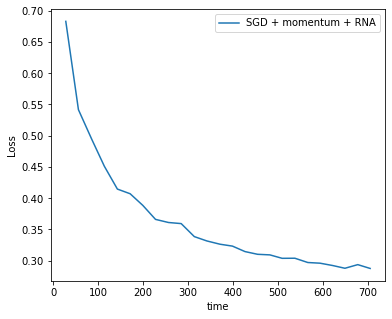

In [39]:
plt.figure(figsize=(6, 5))
plt.plot(time_vec, valid_loss_history, label='SGD + momentum + RNA')
#plt.plot(gd_valid_loss_history, label='GD')
#plt.plot(nest_valid_loss_history, label='NESTROV')

#plt.plot(sgd_valid_acc_history, label='SGD Acc')
#plt.plot(gd_valid_acc_history, label='GD ACC')
#plt.plot(nest_valid_acc_history, label='NESTROV ACC')

plt.xlabel('time')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

In [40]:
##Nestrov plus momentum


#stop_condition = False
K = 10
epochs = 25

nest_valid_loss_history=[]
nest_train_loss_history=[]
nest_time_vec =[]

(train_loader ,validation_loader) = (train_loader, valid_loader) # e.g., CIFAR10

network = net
networkACC = Net().to(DEVICE)

criterion = nn.CrossEntropyLoss()# 

##SGD optimizer

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9, nesterov= True
                      # , dampening = 0
                      # , weight_decay = 0
                      )


#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)

##nesterov (bool, optional) – enables Nesterov momentum (default: False)


accMod = AccelerationModule(network, K=2)

#nest_time_vec.append(0)

start = time.time()

for epoch in range(0, epochs):
    
    nest_train_loss = 0
    nest_valid_loss = 0
    
    # Train for one epoch
    for batch_index, (data, target) in enumerate (train_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)

        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        #output = net(data)
        predictions = network(data)
        #output = model(data)
        
        loss = criterion(predictions, target)
        #loss.forward(predictions , target)
        
        # Backward pass + optimizer step
        loss.backward()
        # rna_optimizer.step()
        optimizer.step()
        # update training loss
        #train_loss += loss.item()*data.size(0)

    
    # Store the gradient estimate , then recover extrapolation
    # rna_optimizer.store()
    # rna_optimizer.accelerate(network_extr)
    # For the online acceleration version , uncomment this line
    # network.load_params(network_extr.params)
    
    # Test on the validation set
    correct = 0
    total = 0

    num_samples = 0
    with torch.no_grad():
        accMod.store(network)
        accMod.accelerate(networkACC)
        
        for batch_index, (data, target) in enumerate (valid_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            predictions = networkACC(data)
            
            num_samples += data.shape[0]
            # loss += img.shape[0] * loss_f(outp, lbl).item()
            loss = criterion(predictions, target)
            pred = predictions.argmax(dim=1)
            
            correct += (pred == target).sum().item()
            # update validation loss
            nest_valid_loss += loss.item()*data.size(0)
   
    elapsed_time_fl = (time.time() - start)
    nest_time_vec.append(elapsed_time_fl)
            
    nest_valid_loss = nest_valid_loss/len(valid_loader.sampler)
    nest_valid_loss_history.append(nest_valid_loss)
            # correct += sum(predictions == target)
            # total += length(targets)
           
    print("Top-1 score: %f", 100.0 * correct/num_samples)


Top-1 score: %f 90.03333333333333
Top-1 score: %f 90.25833333333334
Top-1 score: %f 90.34166666666667
Top-1 score: %f 90.26666666666667
Top-1 score: %f 90.25833333333334
Top-1 score: %f 90.18333333333334
Top-1 score: %f 90.15833333333333
Top-1 score: %f 90.46666666666667
Top-1 score: %f 90.34166666666667
Top-1 score: %f 90.35
Top-1 score: %f 90.51666666666667
Top-1 score: %f 90.25
Top-1 score: %f 90.15833333333333
Top-1 score: %f 90.075
Top-1 score: %f 90.16666666666667
Top-1 score: %f 90.25833333333334
Top-1 score: %f 90.225
Top-1 score: %f 90.18333333333334
Top-1 score: %f 90.34166666666667
Top-1 score: %f 90.425
Top-1 score: %f 90.66666666666667
Top-1 score: %f 90.56666666666666
Top-1 score: %f 90.51666666666667
Top-1 score: %f 90.575
Top-1 score: %f 90.56666666666666


In [41]:



#stop_condition = False
K = 10
epochs = 25

gd_valid_loss_history=[]
gd_train_loss_history=[]
gd_time_vec =[]

(train_loader ,validation_loader) = (train_loader, valid_loader) # e.g., CIFAR10

network = net
networkACC = Net().to(DEVICE)

criterion = nn.CrossEntropyLoss()# 

##SGD optimizer

optimizer = optim.RMSprop(net.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False
                      # , dampening = 0
                      # , weight_decay = 0
                      )
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)




accMod = AccelerationModule(network, K=2)



start = time.time()

for epoch in range(0, epochs):
    
    gd_train_loss = 0
    gd_valid_loss = 0
    
    # Train for one epoch
    for batch_index, (data, target) in enumerate (train_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)

        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        #output = net(data)
        predictions = network(data)
        #output = model(data)
        
        loss = criterion(predictions, target)
        #loss.forward(predictions , target)
        
        # Backward pass + optimizer step
        loss.backward()
        # rna_optimizer.step()
        optimizer.step()
        # update training loss
        #train_loss += loss.item()*data.size(0)

    
    # Store the gradient estimate , then recover extrapolation
    # rna_optimizer.store()
    # rna_optimizer.accelerate(network_extr)
    # For the online acceleration version , uncomment this line
    # network.load_params(network_extr.params)
    
    # Test on the validation set
    correct = 0
    total = 0

    num_samples = 0
    with torch.no_grad():
        accMod.store(network)
        accMod.accelerate(networkACC)
        
        for batch_index, (data, target) in enumerate (valid_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            predictions = networkACC(data)
            
            num_samples += data.shape[0]
            # loss += img.shape[0] * loss_f(outp, lbl).item()
            loss = criterion(predictions, target)
            pred = predictions.argmax(dim=1)
            
            correct += (pred == target).sum().item()
            # update validation loss
            gd_valid_loss += loss.item()*data.size(0)
    
    
    elapsed_time_fl = (time.time() - start)
    gd_time_vec.append(elapsed_time_fl)
            
    gd_valid_loss = gd_valid_loss/len(valid_loader.sampler)
    gd_valid_loss_history.append(gd_valid_loss)
            # correct += sum(predictions == target)
            # total += length(targets)
            
    print("Top-1 score: %f", 100.0 * correct/num_samples)


Top-1 score: %f 89.425
Top-1 score: %f 89.19166666666666
Top-1 score: %f 89.69166666666666
Top-1 score: %f 89.83333333333333
Top-1 score: %f 89.91666666666667
Top-1 score: %f 90.31666666666666
Top-1 score: %f 90.43333333333334
Top-1 score: %f 90.85833333333333
Top-1 score: %f 90.68333333333334
Top-1 score: %f 90.475
Top-1 score: %f 90.88333333333334
Top-1 score: %f 91.10833333333333
Top-1 score: %f 91.1
Top-1 score: %f 91.00833333333334
Top-1 score: %f 91.04166666666667
Top-1 score: %f 90.94166666666666
Top-1 score: %f 90.54166666666667
Top-1 score: %f 90.60833333333333
Top-1 score: %f 90.86666666666666
Top-1 score: %f 90.975
Top-1 score: %f 91.10833333333333
Top-1 score: %f 90.95
Top-1 score: %f 91.1
Top-1 score: %f 91.175
Top-1 score: %f 91.19166666666666


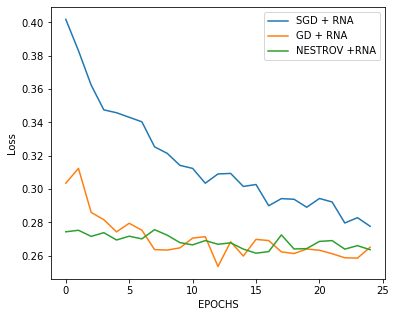

In [42]:
plt.figure(figsize=(6, 5))
plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV +RNA')

plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV +RNA')

#plt.plot(sgd_valid_acc_history, label='SGD Acc')
#plt.plot(gd_valid_acc_history, label='GD ACC')
#plt.plot(nest_valid_acc_history, label='NESTROV ACC')

plt.xlabel('EPOCHS')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

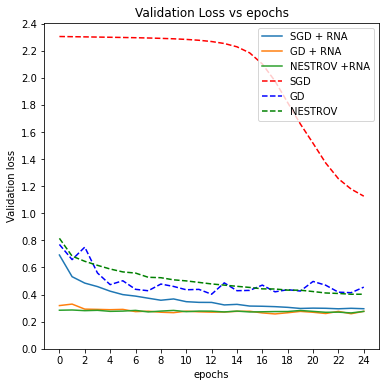

In [69]:

plt.figure(figsize=(6, 6))
plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV +RNA')

plt.plot(sgd1_valid_loss_history,'r--', label='SGD')
plt.plot(gd1_valid_loss_history,'b--', label='GD')
plt.plot(nest1_valid_loss_history, 'g--', label='NESTROV')


plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.yticks(np.arange(0, 2.5, step=0.2))
plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs epochs")
plt.show()

In [42]:
import torch as T
import numpy as np
from numpy import linalg as LA
from torch.optim import Optimizer, SGD
import copy

class online_rna(SGD):
    
    def __init__(self,params, lr,momentum=0.9,dampening=0,weight_decay=0,nesterov=False,K=10,reg_acc=1e-5,acceleration_type='online',do_average=False):
        
        self.params = list(params)
        
        super(online_rna, self).__init__(self.params, lr, momentum, dampening, weight_decay, nesterov)
        self.K = K
        self.reg_acc = reg_acc
        self.do_average = do_average
        
        self.acceleration_type = acceleration_type
        
        for group in self.param_groups:
            group['running_avg_model'] = dict()
            group['running_avg_grad'] = dict()
            group['avg_model_hist'] = dict()
            group['avg_grad_hist'] = dict()
            group['avg_counter'] = dict()
        self.reset_buffers()
        
        if(acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_buffers(self):
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                avg_model_hist[param] = []
                avg_grad_hist[param] = []
        self.reset_running_avg()
        
        if(self.acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_running_avg(self):
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                avg_counter[param] = 0
                running_avg_model[param] = None
                running_avg_grad[param] = None


    def update_lr(self,lr):
        for group in self.param_groups:
            group['lr'] = lr
            
            
    def update_running_avg(self):
        
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            
            for param in group['params']:
                avg_counter[param] += 1
                if(avg_counter[param] == 1):
                    running_avg_model[param] = param.data.clone()
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = param.grad.data.clone()
                else:
                    # weight_avg_x = (avg_counter[param]-1)/avg_counter[param]
                    weight_avg_x = 0 #take the last one
                    
                    weight_avg_grad = (avg_counter[param]-1)/avg_counter[param]
                    # weight_avg_grad = 0 #take the last one
                    
                    running_avg_model[param] = running_avg_model[param].mul(weight_avg_x) + param.data.clone().mul(1-weight_avg_x)
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = running_avg_grad[param].mul(weight_avg_grad) + param.grad.data.clone().mul(1-weight_avg_grad)
        
    
    def step(self):
        super(online_rna, self).step()
        self.update_running_avg()
             
    
    def store(self,model=None):
        
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                if(len(avg_model_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_model_hist[param].pop(0)
                if(len(avg_grad_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_grad_hist[param].pop(0)
        
                avg_model_hist[param].append(copy.deepcopy(running_avg_model[param]))
                if(running_avg_grad[param] is not None):
                    avg_grad_hist[param].append(copy.deepcopy(running_avg_grad[param].cpu().numpy().ravel()))
        self.reset_running_avg()
        # self.reset_momentum()
        
        
        if(self.acceleration_type == 'offline'):
            if(model is None):
                raise ValueError('Problem in rna.store(): model cannot be none in offline acceleration')
                
            if(len(self.dict_hist)>=(self.K)): # with this, len(hist) < K
                self.dict_hist.pop(0)
            self.dict_hist.append(copy.deepcopy(model.state_dict()))
        
    
    def reset_momentum(self):
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'momentum_buffer' in param_state:
                    param_state['momentum_buffer'].mul_(0)
    
    def compute_c_rna(self):
        
        gradient_buffer = []
        for group in self.param_groups:
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                if(len(avg_grad_hist[param]) == 0):
                    continue
                entry = np.asmatrix(avg_grad_hist[param])
                gradient_buffer.append(entry)
        gradient_buffer = np.concatenate(gradient_buffer,axis=1)
        
        R = np.asmatrix(gradient_buffer)
        (k,d) = np.shape(R)
        
        RR = np.dot(R,np.transpose(R))
        normRR = LA.norm(RR,2)
        RR = RR/normRR
        
        reg_I = self.reg_acc*np.eye(k)
        ones_k = np.ones(k)
        
        try:
            z = np.linalg.solve(RR+reg_I, ones_k)
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1)
            z = z[0]
        
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        
        c = (z/np.sum(z)).tolist()
        
        return c
    
    def accelerate(self,model=None):
        c_vec = self.compute_c_rna()

        if(self.do_average):
            k = len(c_vec)
            z = np.ones(k)
            c_vec = (z/np.sum(z)).tolist()
        
        if(self.acceleration_type.lower() == 'online'):
            for group in self.param_groups:
                avg_model_hist = group['avg_model_hist']
                for param in group['params']:
                    param.data.mul_(0.0);
                    for (i, c) in enumerate(c_vec):
                        param.data.add_(c,avg_model_hist[param][i])
        
        if(self.acceleration_type.lower() == 'none'):
            print('No acceleration')
            pass
        
        
        if(self.acceleration_type.lower() == 'offline'):
            if(model is not None):
                    
                new_dict = dict(model.state_dict())
                for key in new_dict:
                    new_dict[key].mul_(0);
                    for idx_c in range(0,len(c_vec)):
                        new_dict[key].add_(c_vec[idx_c],self.dict_hist[idx_c][key])
                model.load_state_dict(new_dict)
            else:
                raise ValueError('Problem in rna.accelerate(): model cannot be none in offline acceleration')
        
        return c_vec


In [43]:
import argparse
from torch.autograd import Variable

#import online_rna
from copy import deepcopy
#import csv




class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10) 
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
        
net = Net()
print(net)
net2 = net


Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [44]:
# In[]:
def lr_scheduler(max_epoch,lr_0,lr_final,epoch):
    epoch_stabilization = 10;
    if(epoch<max_epoch-epoch_stabilization):
        lr = lr_final + (lr_0-lr_final)*(1-(1.0*epoch/(1.0*(max_epoch-epoch_stabilization-1))))
    else:
        lr = lr_final
    return lr;
#weight_decay=1e-5
# In[]:

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
new_lr = lr_scheduler(25,lr_0=1,lr_final = 0.001,epoch=0)
optimizer = online_rna(net.parameters(),lr=new_lr,momentum=0.9,weight_decay=1e-8,nesterov=False,K=10,reg_acc=0,acceleration_type='online',do_average=False)

# In[]:
#define test/validation function
val_arr=[]
def test(net): # tag:RNA # We have to specify the input
    valid_loss = 0
    global val_arr
 
    net.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    valid_loss = valid_loss/len(valid_loader.sampler)

    val_arr.append(valid_loss) 
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nValidation Loss: {round(valid_loss, 6)}')
    


In [45]:
#TRAINING :
    
# epochs to train for
epochs = 25
# tracks validation loss change after each epoch
#minimum_validation_loss = np.inf 

osgd_time_vec =[]
start = time.time()

for epoch in range(1, epochs+1):
    train_loss = 0
    # Schedule
    new_lr = lr_scheduler(35,lr_0=0,lr_final=0.01,epoch=epoch)
    optimizer.update_lr(new_lr)
    
    print('\n\n########### EPOCH: ' +str(epoch) + ' WITH LEARNING RATE: ' +str(new_lr)+'\n\n')
    # training steps
    net.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        
        data, target = Variable(data), Variable(target)
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    osgd_time_vec.append(elapsed_time_fl)
        
    train_loss = train_loss/len(train_loader.sampler)
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}')    
 
    test(net) # tag:RNA # test requires now an input
   
    optimizer.store(model=net)
    if(epoch == 1):
        optimizer.reset_buffers()
    if(epoch > 1):
        c = optimizer.accelerate(net2)
        print("\n ACCELERATION \n")
        print(c)
        print("\n")
        test(net2) # tag:RNA # test requires now an input




########### EPOCH: 1 WITH LEARNING RATE: 0.0004166666666666659


Current Epoch: 1
Training Loss: 2.303156
Current Epoch: 1
Validation Loss: 2.300738


########### EPOCH: 2 WITH LEARNING RATE: 0.0008333333333333335


Current Epoch: 2
Training Loss: 2.297057
Current Epoch: 2
Validation Loss: 2.290461

 ACCELERATION 

[1.0]




/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Current Epoch: 2
Validation Loss: 2.290477


########### EPOCH: 3 WITH LEARNING RATE: 0.0012499999999999994


Current Epoch: 3
Training Loss: 2.264954
Current Epoch: 3
Validation Loss: 2.176244

 ACCELERATION 

[1.2984667350928143, -0.29846673509281435]


Current Epoch: 3
Validation Loss: 2.298746


########### EPOCH: 4 WITH LEARNING RATE: 0.001666666666666667


Current Epoch: 4
Training Loss: 2.290178
Current Epoch: 4
Validation Loss: 2.26887

 ACCELERATION 

[0.20569138877530302, -0.5827414752593758, 1.377050086484073]


Current Epoch: 4
Validation Loss: 2.290735


########### EPOCH: 5 WITH LEARNING RATE: 0.0020833333333333346


Current Epoch: 5
Training Loss: 2.226234
Current Epoch: 5
Validation Loss: 1.776314

 ACCELERATION 

[-0.012268423318915244, -0.4145912777346586, 1.5855507583038144, -0.1586910572502404]


Current Epoch: 5
Validation Loss: 2.293797


########### EPOCH: 6 WITH LEARNING RATE: 0.0025000000000000005


Current Epoch: 6
Training Loss: 2.064928
Current Epoch: 6
Vali

Current Epoch: 24
Training Loss: 0.438682
Current Epoch: 24
Validation Loss: 0.389175

 ACCELERATION 

[-0.02081061365604944, 0.04568654033564021, 0.030432011686588177, 0.04308725916626126, 0.07140601714520622, 0.08999342639657003, 0.13788225712952187, 0.1706245993542967, 0.208893009163562, 0.22280549327840282]


Current Epoch: 24
Validation Loss: 0.377894


########### EPOCH: 25 WITH LEARNING RATE: 0.01


Current Epoch: 25
Training Loss: 0.431976
Current Epoch: 25
Validation Loss: 0.376016

 ACCELERATION 

[0.03393040893681349, 0.01970646228430965, 0.02747545882074244, 0.04943056974605365, 0.06205407995821285, 0.1084186524698317, 0.13068293135491046, 0.16587371364679185, 0.1855979357839729, 0.21682978699836092]


Current Epoch: 25
Validation Loss: 0.371072


hahouwa:  [2.2904771089553835, 2.2987461149692536, 2.290734867254893, 2.2937965015570323, 2.292262097199758, 2.2921428779760995, 2.291969682772954, 2.2919316867987316, 2.2917631804943084, 2.291514637072881, 2.2912560443083447, 2.2942755182584125, 1.765184187889099, 0.5834713498751323, 0.5223310525218646, 0.47142001042763393, 0.4442885391414165, 0.42045407369732857, 0.40568336049715675, 0.40008071971436343, 0.395220885053277, 0.3842719323933125, 0.37789394383629166, 0.3710722204297781]


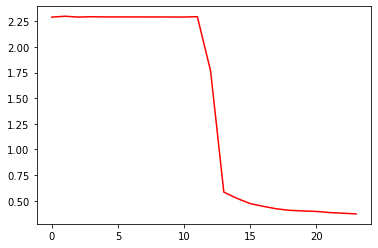

In [46]:
# In[]:
cut=val_arr[1:]
rna_online=[cut[i] for i in range(len(cut)) if i % 2 == 1]
print("hahouwa: ", rna_online)
# In[]:
#Plot loss
#np.save('online_rna_sgd.npy', rna_online)

# In[]:
plt.plot(rna_online, 'r')
#cnn_online.py

GD PLUS ONLINE RNA

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)
#optimizer2 = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [47]:
from torch.optim import Optimizer, RMSprop

class online_rna(RMSprop):
    
    def __init__(self,params, lr=0.01,momentum=0,dampening=0,weight_decay=0,nesterov=False,K=10,alpha=0.99,reg_acc=1e-5,acceleration_type='online',do_average=False):
        
        self.params = list(params)
        
        super(online_rna, self).__init__(self.params, lr, alpha, momentum, dampening, weight_decay, nesterov)
        self.K = K
        self.reg_acc = reg_acc
        self.do_average = do_average
        
        self.acceleration_type = acceleration_type
        
        for group in self.param_groups:
            group['running_avg_model'] = dict()
            group['running_avg_grad'] = dict()
            group['avg_model_hist'] = dict()
            group['avg_grad_hist'] = dict()
            group['avg_counter'] = dict()
        self.reset_buffers()
        
        if(acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_buffers(self):
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                avg_model_hist[param] = []
                avg_grad_hist[param] = []
        self.reset_running_avg()
        
        if(self.acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_running_avg(self):
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                avg_counter[param] = 0
                running_avg_model[param] = None
                running_avg_grad[param] = None


    def update_lr(self,lr):
        for group in self.param_groups:
            group['lr'] = lr
            
            
    def update_running_avg(self):
        
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            
            for param in group['params']:
                avg_counter[param] += 1
                if(avg_counter[param] == 1):
                    running_avg_model[param] = param.data.clone()
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = param.grad.data.clone()
                else:
                    # weight_avg_x = (avg_counter[param]-1)/avg_counter[param]
                    weight_avg_x = 0 #take the last one
                    
                    weight_avg_grad = (avg_counter[param]-1)/avg_counter[param]
                    # weight_avg_grad = 0 #take the last one
                    
                    running_avg_model[param] = running_avg_model[param].mul(weight_avg_x) + param.data.clone().mul(1-weight_avg_x)
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = running_avg_grad[param].mul(weight_avg_grad) + param.grad.data.clone().mul(1-weight_avg_grad)
        
    
    def step(self):
        super(online_rna, self).step()
        self.update_running_avg()
             
    
    def store(self,model=None):
        
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                if(len(avg_model_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_model_hist[param].pop(0)
                if(len(avg_grad_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_grad_hist[param].pop(0)
        
                avg_model_hist[param].append(copy.deepcopy(running_avg_model[param]))
                if(running_avg_grad[param] is not None):
                    avg_grad_hist[param].append(copy.deepcopy(running_avg_grad[param].cpu().numpy().ravel()))
        self.reset_running_avg()
        # self.reset_momentum()
        
        
        if(self.acceleration_type == 'offline'):
            if(model is None):
                raise ValueError('Problem in rna.store(): model cannot be none in offline acceleration')
                
            if(len(self.dict_hist)>=(self.K)): # with this, len(hist) < K
                self.dict_hist.pop(0)
            self.dict_hist.append(copy.deepcopy(model.state_dict()))
        
    
    def reset_momentum(self):
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'momentum_buffer' in param_state:
                    param_state['momentum_buffer'].mul_(0)
    
    def compute_c_rna(self):
        
        gradient_buffer = []
        for group in self.param_groups:
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                if(len(avg_grad_hist[param]) == 0):
                    continue
                entry = np.asmatrix(avg_grad_hist[param])
                gradient_buffer.append(entry)
        gradient_buffer = np.concatenate(gradient_buffer,axis=1)
        
        R = np.asmatrix(gradient_buffer)
        (k,d) = np.shape(R)
        
        RR = np.dot(R,np.transpose(R))
        normRR = LA.norm(RR,2)
        RR = RR/normRR
        
        reg_I = self.reg_acc*np.eye(k)
        ones_k = np.ones(k)
        
        try:
            z = np.linalg.solve(RR+reg_I, ones_k)
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1)
            z = z[0]
        
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        
        c = (z/np.sum(z)).tolist()
        
        return c
    
    def accelerate(self,model=None):
        c_vec = self.compute_c_rna()

        if(self.do_average):
            k = len(c_vec)
            z = np.ones(k)
            c_vec = (z/np.sum(z)).tolist()
        
        if(self.acceleration_type.lower() == 'online'):
            for group in self.param_groups:
                avg_model_hist = group['avg_model_hist']
                for param in group['params']:
                    param.data.mul_(0.0);
                    for (i, c) in enumerate(c_vec):
                        param.data.add_(c,avg_model_hist[param][i])
        
        if(self.acceleration_type.lower() == 'none'):
            print('No acceleration')
            pass
        
        
        if(self.acceleration_type.lower() == 'offline'):
            if(model is not None):
                    
                new_dict = dict(model.state_dict())
                for key in new_dict:
                    new_dict[key].mul_(0);
                    for idx_c in range(0,len(c_vec)):
                        new_dict[key].add_(c_vec[idx_c],self.dict_hist[idx_c][key])
                model.load_state_dict(new_dict)
            else:
                raise ValueError('Problem in rna.accelerate(): model cannot be none in offline acceleration')
        
        return c_vec


In [48]:
# In[]:
def lr_scheduler(max_epoch,lr_0,lr_final,epoch):
    epoch_stabilization = 10;
    if(epoch<max_epoch-epoch_stabilization):
        lr = lr_final + (lr_0-lr_final)*(1-(1.0*epoch/(1.0*(max_epoch-epoch_stabilization-1))))
    else:
        lr = lr_final
    return lr;
#weight_decay=1e-5
# In[]:

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
new_lr = lr_scheduler(25,lr_0=1,lr_final = 0.001,epoch=0)
optimizer2 = online_rna(net.parameters(),lr=new_lr,momentum=0.9,weight_decay=1e-8,alpha = 0.99,nesterov=False,K=10,reg_acc=0,acceleration_type='online',do_average=False)

# In[]:
#define test/validation function
gd_val_arr=[]
def test(net): # tag:RNA # We have to specify the input
    gd_valid_loss = 0
    global gd_val_arr
 
    net.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        gd_valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    gd_valid_loss = gd_valid_loss/len(valid_loader.sampler)

    gd_val_arr.append(gd_valid_loss) 
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nValidation Loss: {round(gd_valid_loss, 6)}')
    


In [49]:
#TRAINING :
    
# epochs to train for
epochs = 25
# tracks validation loss change after each epoch
#minimum_validation_loss = np.inf 
ogd_time_vec = []
start = time.time()
for epoch in range(1, epochs+1):
    gd_train_loss = 0
    # Schedule
    new_lr = lr_scheduler(25,lr_0=0,lr_final=0.01,epoch=epoch)
    optimizer2.update_lr(new_lr)
    
    print('\n\n########### EPOCH: ' +str(epoch) + ' WITH LEARNING RATE: ' +str(new_lr)+'\n\n')
    # training steps
    net.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        
        data, target = Variable(data), Variable(target)
        # clears gradients
        optimizer2.zero_grad()
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer2.step()
        # update training loss
        gd_train_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start)
    ogd_time_vec.append(elapsed_time_fl)
        
    gd_train_loss = gd_train_loss/len(train_loader.sampler)
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(gd_train_loss, 6)}')    
 
    test(net) # tag:RNA # test requires now an input
   
    optimizer2.store(model=net)
    if(epoch == 1):
        optimizer2.reset_buffers()
    if(epoch > 1):
        c = optimizer2.accelerate(net2)
        print("\n ACCELERATION \n")
        print(c)
        print("\n")
        test(net2) # tag:RNA # test requires now an input




########### EPOCH: 1 WITH LEARNING RATE: 0.0007142857142857142


Current Epoch: 1
Training Loss: 0.398699
Current Epoch: 1
Validation Loss: 0.36664


########### EPOCH: 2 WITH LEARNING RATE: 0.0014285714285714284


Current Epoch: 2
Training Loss: 0.392459
Current Epoch: 2
Validation Loss: 0.362395

 ACCELERATION 

[1.0]


Current Epoch: 2
Validation Loss: 0.364416


########### EPOCH: 3 WITH LEARNING RATE: 0.0021428571428571425


Current Epoch: 3
Training Loss: 0.393102
Current Epoch: 3
Validation Loss: 0.36028

 ACCELERATION 

[0.36109384543510176, 0.6389061545648983]


Current Epoch: 3
Validation Loss: 0.361673


########### EPOCH: 4 WITH LEARNING RATE: 0.0028571428571428567


Current Epoch: 4
Training Loss: 0.391698
Current Epoch: 4
Validation Loss: 0.357489

 ACCELERATION 

[0.09895404858212607, 0.35527339248306483, 0.5457725589348091]


Current Epoch: 4
Validation Loss: 0.359356


########### EPOCH: 5 WITH LEARNING RATE: 0.0035714285714285718


Current Epoch: 5
Training Loss: 0.

Current Epoch: 23
Validation Loss: 0.340229


########### EPOCH: 24 WITH LEARNING RATE: 0.01


Current Epoch: 24
Training Loss: 0.372808
Current Epoch: 24
Validation Loss: 0.338225

 ACCELERATION 

[0.10401721863516283, 0.10669263043938973, 0.0719492650663971, 0.0986133496623146, 0.10354414324316301, 0.10604585226728822, 0.095357968268476, 0.08859698963452718, 0.1050682352599367, 0.1201143475233446]


Current Epoch: 24
Validation Loss: 0.340135


########### EPOCH: 25 WITH LEARNING RATE: 0.01


Current Epoch: 25
Training Loss: 0.373366
Current Epoch: 25
Validation Loss: 0.342846

 ACCELERATION 

[0.10355717154416676, 0.07077570045124533, 0.09965629776172988, 0.10432304358390918, 0.1045870861731511, 0.09535028869742972, 0.0885471352441072, 0.10067402425435683, 0.12325558938619087, 0.10927366290371303]


Current Epoch: 25
Validation Loss: 0.340883


hahouwa:  [0.3644155169526736, 0.36167303125063577, 0.3593555218229691, 0.3581662751734257, 0.3574595142155886, 0.35587300583720205, 0.35273344020048775, 0.35436923801898956, 0.35356976216038066, 0.34976583942770956, 0.352885277569294, 0.3466080306718747, 0.346637607862552, 0.349458164597551, 0.3495887316763401, 0.3423272632062435, 0.34351073987782, 0.3436578291157881, 0.34216733413438, 0.3431048296391964, 0.34067352302372456, 0.3402287485698859, 0.34013460005323093, 0.34088290532430016]


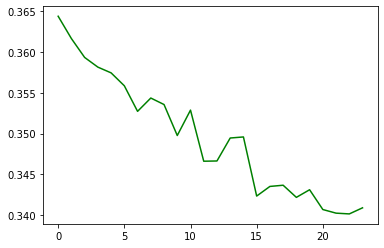

In [50]:
cut2=gd_val_arr[1:]
rna_online2=[cut2[i] for i in range(len(cut)) if i % 2 == 1]
print("hahouwa: ", rna_online2)
# In[]:
#Plot loss
np.save('online_rna_sgd.npy', rna_online2)

# In[]:
plt.plot(rna_online2, 'g')
#cnn_online.py

NESTROV PLUS ONLINE RNA

In [ ]:
#optimizer3 = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)

In [51]:

class online_rna(SGD):
    
    def __init__(self,params, lr,momentum=0,dampening=0,weight_decay=0,nesterov=True,K=10,reg_acc=1e-5,acceleration_type='online',do_average=False):
        
        self.params = list(params)
        
        super(online_rna, self).__init__(self.params, lr, momentum, dampening, weight_decay, nesterov)
        self.K = K
        self.reg_acc = reg_acc
        self.do_average = do_average
        
        self.acceleration_type = acceleration_type
        
        for group in self.param_groups:
            group['running_avg_model'] = dict()
            group['running_avg_grad'] = dict()
            group['avg_model_hist'] = dict()
            group['avg_grad_hist'] = dict()
            group['avg_counter'] = dict()
        self.reset_buffers()
        
        if(acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_buffers(self):
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                avg_model_hist[param] = []
                avg_grad_hist[param] = []
        self.reset_running_avg()
        
        if(self.acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_running_avg(self):
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                avg_counter[param] = 0
                running_avg_model[param] = None
                running_avg_grad[param] = None


    def update_lr(self,lr):
        for group in self.param_groups:
            group['lr'] = lr
            
            
    def update_running_avg(self):
        
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            
            for param in group['params']:
                avg_counter[param] += 1
                if(avg_counter[param] == 1):
                    running_avg_model[param] = param.data.clone()
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = param.grad.data.clone()
                else:
                    # weight_avg_x = (avg_counter[param]-1)/avg_counter[param]
                    weight_avg_x = 0 #take the last one
                    
                    weight_avg_grad = (avg_counter[param]-1)/avg_counter[param]
                    # weight_avg_grad = 0 #take the last one
                    
                    running_avg_model[param] = running_avg_model[param].mul(weight_avg_x) + param.data.clone().mul(1-weight_avg_x)
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = running_avg_grad[param].mul(weight_avg_grad) + param.grad.data.clone().mul(1-weight_avg_grad)
        
    
    def step(self):
        super(online_rna, self).step()
        self.update_running_avg()
             
    
    def store(self,model=None):
        
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                if(len(avg_model_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_model_hist[param].pop(0)
                if(len(avg_grad_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_grad_hist[param].pop(0)
        
                avg_model_hist[param].append(copy.deepcopy(running_avg_model[param]))
                if(running_avg_grad[param] is not None):
                    avg_grad_hist[param].append(copy.deepcopy(running_avg_grad[param].cpu().numpy().ravel()))
        self.reset_running_avg()
        # self.reset_momentum()
        
        
        if(self.acceleration_type == 'offline'):
            if(model is None):
                raise ValueError('Problem in rna.store(): model cannot be none in offline acceleration')
                
            if(len(self.dict_hist)>=(self.K)): # with this, len(hist) < K
                self.dict_hist.pop(0)
            self.dict_hist.append(copy.deepcopy(model.state_dict()))
        
    
    def reset_momentum(self):
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'momentum_buffer' in param_state:
                    param_state['momentum_buffer'].mul_(0)
    
    def compute_c_rna(self):
        
        gradient_buffer = []
        for group in self.param_groups:
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                if(len(avg_grad_hist[param]) == 0):
                    continue
                entry = np.asmatrix(avg_grad_hist[param])
                gradient_buffer.append(entry)
        gradient_buffer = np.concatenate(gradient_buffer,axis=1)
        
        R = np.asmatrix(gradient_buffer)
        (k,d) = np.shape(R)
        
        RR = np.dot(R,np.transpose(R))
        normRR = LA.norm(RR,2)
        RR = RR/normRR
        
        reg_I = self.reg_acc*np.eye(k)
        ones_k = np.ones(k)
        
        try:
            z = np.linalg.solve(RR+reg_I, ones_k)
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1)
            z = z[0]
        
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        
        c = (z/np.sum(z)).tolist()
        
        return c
    
    def accelerate(self,model=None):
        c_vec = self.compute_c_rna()

        if(self.do_average):
            k = len(c_vec)
            z = np.ones(k)
            c_vec = (z/np.sum(z)).tolist()
        
        if(self.acceleration_type.lower() == 'online'):
            for group in self.param_groups:
                avg_model_hist = group['avg_model_hist']
                for param in group['params']:
                    param.data.mul_(0.0);
                    for (i, c) in enumerate(c_vec):
                        param.data.add_(c,avg_model_hist[param][i])
        
        if(self.acceleration_type.lower() == 'none'):
            print('No acceleration')
            pass
        
        
        if(self.acceleration_type.lower() == 'offline'):
            if(model is not None):
                    
                new_dict = dict(model.state_dict())
                for key in new_dict:
                    new_dict[key].mul_(0);
                    for idx_c in range(0,len(c_vec)):
                        new_dict[key].add_(c_vec[idx_c],self.dict_hist[idx_c][key])
                model.load_state_dict(new_dict)
            else:
                raise ValueError('Problem in rna.accelerate(): model cannot be none in offline acceleration')
        
        return c_vec


In [52]:
# In[]:
def lr_scheduler(max_epoch,lr_0,lr_final,epoch):
    epoch_stabilization = 10;
    if(epoch<max_epoch-epoch_stabilization):
        lr = lr_final + (lr_0-lr_final)*(1-(1.0*epoch/(1.0*(max_epoch-epoch_stabilization-1))))
    else:
        lr = lr_final
    return lr;
#weight_decay=1e-5
# In[]:

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
new_lr = lr_scheduler(25,lr_0=1,lr_final = 0.001,epoch=0)
optimizer3 = online_rna(net.parameters(),lr=new_lr,momentum=0.9,weight_decay=1e-5,nesterov=True,K=10,reg_acc=0,acceleration_type='online',do_average=False)

# In[]:
#define test/validation function
nest_val_arr=[]
def test(net): # tag:RNA # We have to specify the input
    nest_valid_loss = 0
    global nest_val_arr
 
    net.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        nest_valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    nest_valid_loss = nest_valid_loss/len(valid_loader.sampler)

    nest_val_arr.append(nest_valid_loss) 
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nValidation Loss: {round(nest_valid_loss, 6)}')
    


In [53]:
#TRAINING :
    
# epochs to train for
epochs = 25
# tracks validation loss change after each epoch
#minimum_validation_loss = np.inf 
onest_time_vec = []
start = time.time()
for epoch in range(1, epochs+1):
    nest_train_loss = 0
    # Schedule
    new_lr = lr_scheduler(25,lr_0=0,lr_final=0.01,epoch=epoch)
    optimizer3.update_lr(new_lr)
    
    print('\n\n########### EPOCH: ' +str(epoch) + ' WITH LEARNING RATE: ' +str(new_lr)+'\n\n')
    # training steps
    net.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        
        data, target = Variable(data), Variable(target)
        # clears gradients
        optimizer3.zero_grad()
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer3.step()
        # update training loss
        nest_train_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start)
    onest_time_vec.append(elapsed_time_fl)
        
    nest_train_loss = nest_train_loss/len(train_loader.sampler)
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(nest_train_loss, 6)}')    
 
    test(net) # tag:RNA # test requires now an input
   
    optimizer3.store(model=net)
    if(epoch == 1):
        optimizer3.reset_buffers()
    if(epoch > 1):
        c = optimizer3.accelerate(net2)
        print("\n ACCELERATION \n")
        print(c)
        print("\n")
        test(net2) # tag:RNA # test requires now an input




########### EPOCH: 1 WITH LEARNING RATE: 0.0007142857142857142


Current Epoch: 1
Training Loss: 0.36958
Current Epoch: 1
Validation Loss: 0.341902


########### EPOCH: 2 WITH LEARNING RATE: 0.0014285714285714284


Current Epoch: 2
Training Loss: 0.372793
Current Epoch: 2
Validation Loss: 0.345292

 ACCELERATION 

[1.0]


Current Epoch: 2
Validation Loss: 0.343189


########### EPOCH: 3 WITH LEARNING RATE: 0.0021428571428571425


Current Epoch: 3
Training Loss: 0.371993
Current Epoch: 3
Validation Loss: 0.336967

 ACCELERATION 

[0.49289949298570584, 0.5071005070142942]


Current Epoch: 3
Validation Loss: 0.333179


########### EPOCH: 4 WITH LEARNING RATE: 0.0028571428571428567


Current Epoch: 4
Training Loss: 0.369286
Current Epoch: 4
Validation Loss: 0.329212

 ACCELERATION 

[0.31929728942243724, 0.3349801812385569, 0.3457225293390059]


Current Epoch: 4
Validation Loss: 0.331492


########### EPOCH: 5 WITH LEARNING RATE: 0.0035714285714285718


Current Epoch: 5
Training Loss: 0.

Current Epoch: 23
Validation Loss: 0.303369


########### EPOCH: 24 WITH LEARNING RATE: 0.01


Current Epoch: 24
Training Loss: 0.349006
Current Epoch: 24
Validation Loss: 0.316775

 ACCELERATION 

[0.06283035883677511, 0.0788974271313564, 0.08289978505882405, 0.0964161276691112, 0.09387581449812592, 0.10482963635799324, 0.11720067145440967, 0.11255818728769175, 0.11805934948109514, 0.1324326422246175]


Current Epoch: 24
Validation Loss: 0.302577


########### EPOCH: 25 WITH LEARNING RATE: 0.01


Current Epoch: 25
Training Loss: 0.347481
Current Epoch: 25
Validation Loss: 0.315811

 ACCELERATION 

[0.07529810925387723, 0.07834202862294229, 0.08857743167269397, 0.08670442890443372, 0.09753004194916615, 0.11234393917637292, 0.1030769757586117, 0.11164314047106162, 0.12690336923861661, 0.11958053495222387]


Current Epoch: 25
Validation Loss: 0.301133


hahouwa:  [0.34318856162329514, 0.33317908048629763, 0.331492214029034, 0.32924759909510615, 0.32715911231935024, 0.3248841505497694, 0.3270975861698389, 0.32499584729472797, 0.31970681361854075, 0.32241883017122747, 0.31950291867057484, 0.31945239963630834, 0.3167688508828481, 0.3169022699197133, 0.3119374606758356, 0.31135719182590643, 0.30937723964452746, 0.31350435030957063, 0.3043678615242243, 0.3043937576313814, 0.30693085864186287, 0.30336934365332124, 0.30257700718939307, 0.30113288648426534]


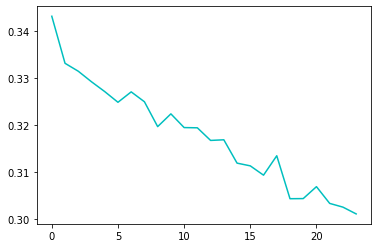

In [54]:
cut3=nest_val_arr[1:]
rna_online3=[cut3[i] for i in range(len(cut)) if i % 2 == 1]
print("hahouwa: ", rna_online3)
# In[]:
#Plot loss
#np.save('online_rna_sgd.npy', rna_online3)

# In[]:
plt.plot(rna_online3, 'c')
#cnn_online.py

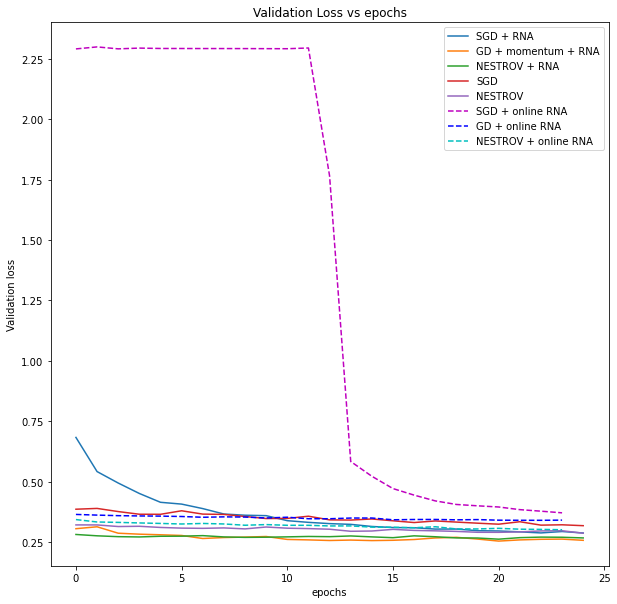

In [74]:
###all epochs combined

plt.figure(figsize=(10, 10))

plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + momentum + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV + RNA')

plt.plot(sgd1_valid_loss_history, label='SGD')
#plt.plot(gd1_valid_loss_history, label='GD')
#plt.plot(gdm1_valid_loss_history, label='GD + momentum')
plt.plot(nest1_valid_loss_history, label='NESTROV')


plt.plot(rna_online,'m--', label='SGD + online RNA')
plt.plot(rna_online2,'b--' , label='GD + online RNA')
plt.plot(rna_online3,'c--', label='NESTROV + online RNA')

plt.legend(loc="upper right")
plt.xlabel('epochs')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs epochs")
plt.show()


In [ ]:
#plt of time GD and Nestrov
plt.figure(figsize=(10, 10))


plt.plot(gd1_time, gd1_valid_loss_history, label='GD')
plt.plot(gdm1_time, gdm1_valid_loss_history, label='GD + momentum')
plt.legend(loc="upper right")
plt.xlabel('time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, , step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

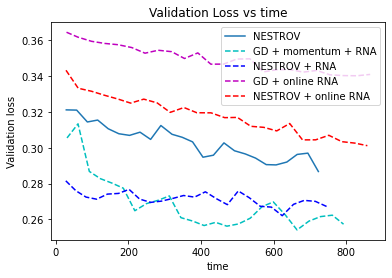

In [78]:

plt.plot(nest1_time, nest1_valid_loss_history, label='NESTROV')


plt.plot(gd_time_vec, gd_valid_loss_history,'c--', label='GD + momentum + RNA')
plt.plot(nest_time_vec, nest_valid_loss_history, 'b--', label='NESTROV + RNA')

plt.plot(ogd_time_vec[:-1], rna_online2,'m--', label='GD + online RNA')
plt.plot(onest_time_vec[:-1], rna_online3,'r--', label='NESTROV + online RNA')

plt.legend(loc="upper right")
plt.xlabel('time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, , step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

#plt.xlabel('EPOCHS')
#plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
#plt.legend()
#plt.show()

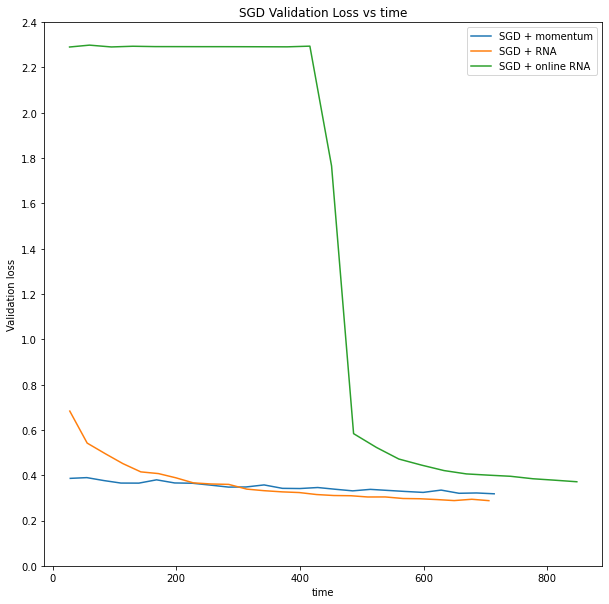

In [66]:
##time SGD
plt.figure(figsize=(10, 10))


plt.plot(sgd1_time, sgd1_valid_loss_history, label='SGD + momentum')
plt.plot(time_vec, valid_loss_history, label='SGD + RNA')
plt.plot(osgd_time_vec[:-1], rna_online, label='SGD + online RNA')

#
plt.legend(loc="upper right")
plt.xlabel('time')
plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, , step=2))
plt.ylabel('Validation loss')
plt.title("SGD Validation Loss vs time")
plt.show()


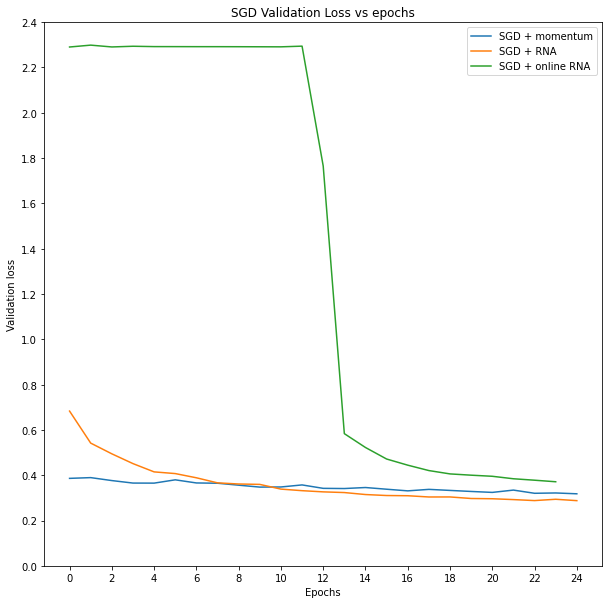

In [67]:
##epochs SGD
plt.figure(figsize=(10, 10))


plt.plot(sgd1_valid_loss_history, label='SGD + momentum')
plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(rna_online, label='SGD + online RNA')

#
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.yticks(np.arange(0, 2.5, step=0.2))
plt.xticks(np.arange(0, 26 , step=2))
plt.ylabel('Validation loss')
plt.title("SGD Validation Loss vs epochs")
plt.show()
